<a href="https://colab.research.google.com/github/aljeshishe/notebooks/blob/master/vgg_gpu_v2_with_wb_graph_samples_count_dependance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np 
import matplotlib.pyplot as plt 
import sys 

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from time import time 

In [2]:
import os
# use gpu/cpu/tpu
# see details in https://colab.research.google.com/drive/1cpuwjKTJbMjlvZ7opyrWzMXF_NYnjkiE#scrollTo=y3gk7nSvTUFZ
gpus = tf.config.experimental.list_physical_devices('GPU')
COLAB_TPU_ADDR = os.environ.get('COLAB_TPU_ADDR')
if COLAB_TPU_ADDR:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + COLAB_TPU_ADDR)
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
  print('Running on TPU ')  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)
!nvidia-smi

Running on single GPU  /physical_device:GPU:0
Number of accelerators:  1
Mon May  4 11:38:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:   

In [3]:
from google.colab import drive
drive.mount('/content/drive')

def notebook_name():
  import re
  import ipykernel
  import requests

  from notebook.notebookapp import list_running_servers
  # kernel_id = re.search('kernel-(.*).json', ipykernel.connect.get_connection_file()).group(1)
  for ss in list_running_servers():
      response = requests.get(f'{ss["url"]}api/sessions',params={'token': ss.get('token', '')})
      return response.json()[0]['name']


project, _, _ = notebook_name().rpartition('.')

import re 
project = re.sub('[^-a-zA-Z0-9_]+', '_', project)

working_dir = f'/content/drive/My Drive/Colab Notebooks/{project}'
print(f'Current project: {project}')
print(f'Places at: {working_dir}')

import pathlib
pathlib.Path(working_dir).mkdir(parents=True, exist_ok=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Current project: vgg_gpu_v2_with_wb_graph_samples_count_dependance
Places at: /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance


In [4]:
labels = [
    'airplane', 
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

#load dataset
(trainX, trainY),(testX, testY) = cifar10.load_data()

#one hot encode the target 
trainY = keras.utils.to_categorical(trainY)
testY = keras.utils.to_categorical(testY)

# normalize the data
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

v_split = 0.5
index_of_validation = int(v_split * len(testX))
validX = np.asarray(testX[-index_of_validation:])
validY = np.asarray(testY[-index_of_validation:])
testX = np.asarray(testX[:-index_of_validation])
testY = np.asarray(testY[:-index_of_validation])

print(f'Prepared dataset:')
print(f'trainX:{trainX.shape}')
print(f'trainY:{trainY.shape}')
print(f'validX:{validX.shape}')
print(f'validY:{validY.shape}')
print(f'testX:{testX.shape}')
print(f'testY:{testY.shape}')
print(f'labels:{" ".join(labels)}')


170500096/170498071 [==============================] - 3s 0us/step
Prepared dataset:
trainX:(50000, 32, 32, 3)
trainY:(50000, 10)
validX:(5000, 32, 32, 3)
validY:(5000, 10)
testX:(5000, 32, 32, 3)
testY:(5000, 10)
labels:airplane automobile bird cat deer dog frog horse ship truck


In [0]:
# define model
def baseline():
    model = Sequential()
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same', input_shape = (32,32,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))
   

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))
    
    #compile model 
    opt = SGD(lr = config.lr, momentum=config.momentum)
    model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model


In [9]:
import wandb
from wandb.keras import WandbCallback
results = []
results_count = []
steps = 10
for step in range(1, steps+1):
  config = dict(
    batch_size = 64,          # input batch size for training (default: 64)
    epochs = 5,             # number of epochs to train (default: 10)
    lr = 0.001,               # learning rate (default: 0.01)
    momentum = 0.9,          # SGD momentum (default: 0.5) 
    seed = 42,               # random seed (default: 42)
    log_interval = 10,     # how many batches to wait before logging training status
    weight_decay = 0.0005
  )
  wandb.init(project=project, dir=working_dir, config=config)
  config = wandb.config
  with strategy.scope():
    model = baseline()
  count = int(len(trainX)/steps * step)
  part_x = trainX[:count]
  part_y = trainY[:count]
  steps_per_epoch = int(len(trainX) / config.batch_size)
  print(f'step={step} count={count} steps_per_epoch={steps_per_epoch}')
  h = model.fit(x=part_x, 
            y=part_y, 
            batch_size=config.batch_size,
            initial_epoch=0,
            epochs=config.epochs,
            validation_data=(validX, validY), verbose=0,
            callbacks=[WandbCallback(data_type="image",
                                      validation_data=(validX, validY),
                                      labels=labels,
                                      predictions=10,
                                      save_model=True,
                                      verbose=1)])

  results.append(h.history)
  results_count.append(count)

step=1 count=5000 steps_per_epoch=781
Epoch 00000: val_loss improved from inf to 2.39470, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114122-3ielpb0q/model-best.h5
Epoch 00003: val_loss improved from 2.39470 to 2.12591, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114122-3ielpb0q/model-best.h5
Epoch 00004: val_loss improved from 2.12591 to 1.97124, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114122-3ielpb0q/model-best.h5


step=2 count=10000 steps_per_epoch=781
Epoch 00000: val_loss improved from inf to 2.51064, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114137-2cgubt96/model-best.h5
Epoch 00001: val_loss improved from 2.51064 to 1.90947, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114137-2cgubt96/model-best.h5
Epoch 00002: val_loss improved from 1.90947 to 1.60591, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114137-2cgubt96/model-best.h5
Epoch 00003: val_loss improved from 1.60591 to 1.52734, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114137-2cgubt96/model-best.h5
Epoch 00004: val_loss improved from 1.52734 to 1.46337, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v

step=3 count=15000 steps_per_epoch=781
Epoch 00000: val_loss improved from inf to 2.27711, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114150-1z4wji1l/model-best.h5
Epoch 00001: val_loss improved from 2.27711 to 1.63978, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114150-1z4wji1l/model-best.h5
Epoch 00002: val_loss improved from 1.63978 to 1.59692, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114150-1z4wji1l/model-best.h5
Epoch 00003: val_loss improved from 1.59692 to 1.50584, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114150-1z4wji1l/model-best.h5
Epoch 00004: val_loss improved from 1.50584 to 1.45699, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v

step=4 count=20000 steps_per_epoch=781
Epoch 00000: val_loss improved from inf to 2.14219, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114205-369n1ue6/model-best.h5
Epoch 00001: val_loss improved from 2.14219 to 1.56794, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114205-369n1ue6/model-best.h5
Epoch 00003: val_loss improved from 1.56794 to 1.45504, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114205-369n1ue6/model-best.h5


step=5 count=25000 steps_per_epoch=781
Epoch 00000: val_loss improved from inf to 1.84891, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114225-1t4899pu/model-best.h5
Epoch 00001: val_loss improved from 1.84891 to 1.49332, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114225-1t4899pu/model-best.h5
Epoch 00002: val_loss improved from 1.49332 to 1.40915, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114225-1t4899pu/model-best.h5
Epoch 00003: val_loss improved from 1.40915 to 1.39025, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114225-1t4899pu/model-best.h5
Epoch 00004: val_loss improved from 1.39025 to 1.34346, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v

step=6 count=30000 steps_per_epoch=781
Epoch 00000: val_loss improved from inf to 1.65250, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114247-pdrg5nch/model-best.h5
Epoch 00001: val_loss improved from 1.65250 to 1.50773, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114247-pdrg5nch/model-best.h5
Epoch 00002: val_loss improved from 1.50773 to 1.35058, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114247-pdrg5nch/model-best.h5
Epoch 00004: val_loss improved from 1.35058 to 1.33718, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114247-pdrg5nch/model-best.h5


step=7 count=35000 steps_per_epoch=781
Epoch 00000: val_loss improved from inf to 1.56989, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114313-1mxbh1f5/model-best.h5
Epoch 00001: val_loss improved from 1.56989 to 1.40746, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114313-1mxbh1f5/model-best.h5
Epoch 00002: val_loss improved from 1.40746 to 1.34783, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114313-1mxbh1f5/model-best.h5
Epoch 00003: val_loss improved from 1.34783 to 1.30677, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114313-1mxbh1f5/model-best.h5
Epoch 00004: val_loss improved from 1.30677 to 1.26127, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v

step=8 count=40000 steps_per_epoch=781
Epoch 00000: val_loss improved from inf to 1.88243, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114343-2i7wpluh/model-best.h5
Epoch 00001: val_loss improved from 1.88243 to 1.50727, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114343-2i7wpluh/model-best.h5
Epoch 00002: val_loss improved from 1.50727 to 1.43183, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114343-2i7wpluh/model-best.h5
Epoch 00003: val_loss improved from 1.43183 to 1.32029, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114343-2i7wpluh/model-best.h5


step=9 count=45000 steps_per_epoch=781
Epoch 00000: val_loss improved from inf to 1.51620, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114413-mw2z8pzq/model-best.h5
Epoch 00001: val_loss improved from 1.51620 to 1.39787, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114413-mw2z8pzq/model-best.h5
Epoch 00002: val_loss improved from 1.39787 to 1.37882, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114413-mw2z8pzq/model-best.h5
Epoch 00003: val_loss improved from 1.37882 to 1.25437, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114413-mw2z8pzq/model-best.h5
Epoch 00004: val_loss improved from 1.25437 to 1.17262, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v

step=10 count=50000 steps_per_epoch=781
Epoch 00000: val_loss improved from inf to 1.47607, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114450-2q3acgtt/model-best.h5
Epoch 00001: val_loss improved from 1.47607 to 1.30475, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114450-2q3acgtt/model-best.h5
Epoch 00002: val_loss improved from 1.30475 to 1.24169, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114450-2q3acgtt/model-best.h5
Epoch 00003: val_loss improved from 1.24169 to 1.17608, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_v2_with_wb_graph_samples_count_dependance/wandb/run-20200504_114450-2q3acgtt/model-best.h5
Epoch 00004: val_loss improved from 1.17608 to 1.14222, saving model to /content/drive/My Drive/Colab Notebooks/vgg_gpu_

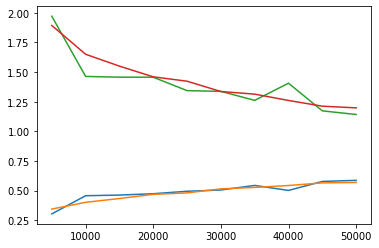

In [10]:
val_acc = [(i, result['val_accuracy'][-1]) for i, result in zip(results_count, results)]
acc = [(i, result['accuracy'][-1]) for i, result in zip(results_count, results)]
val_loss = [(i, result['val_loss'][-1]) for i, result in zip(results_count, results)]
loss = [(i, result['loss'][-1]) for i, result in zip(results_count, results)]
import matplotlib.pyplot as plt
plt.plot(*zip(*val_acc))
plt.plot(*zip(*acc))
plt.plot(*zip(*val_loss))
plt.plot(*zip(*loss))